In [72]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15309817624570339663
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 636923198270029634
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11649695522064287201
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14640891840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17820523524679765675
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [73]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [74]:
tf.__version__

'2.3.0'

In [75]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [76]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib

In [77]:
data_dir = '/content/drive/My Drive/Cane_Toad_Image_Classification/datasets'
data_dir = pathlib.Path(data_dir)

output_dir = '/content/drive/My Drive/Cane_Toad_Image_Classification/outputs'

model_dir = '/content/drive/My Drive/Cane_Toad_Image_Classification/models'

In [78]:
attempt = 1
save_output = False

# if false, sample images won't be visualised after datasets are generated
view_samples = True

# if true, the model found at `model_path` will be loaded,
# else a new model will be compiled
model_path = model_dir + 'model_{}.h5'.format(attempt)
load_model = False

# if false, training will be skipped
train = True

# model will be saved if train == true and save_model == true
save_model = False

In [79]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

119

In [80]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*')])
CLASS_NAMES

array(['cane_toad', 'native_frog'], dtype='<U11')

In [81]:
import platform

num_skipped = 0

for folder_name in CLASS_NAMES:
    folder_path = os.path.join(data_dir, folder_name)
    
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        fobj = open(fpath, "rb")
        
        if tf.compat.as_bytes("JFIF") not in fobj.peek(10):
            print(fpath)
            num_skipped += 1
            fobj.close()
            
            # Delete corrupted image
            !rm "{fpath}"
            
print("Deleted %d images" % num_skipped)

Deleted 0 images


In [82]:
DATASET_SIZE = len(list(data_dir.glob('*/*.jpg')))
DATASET_SIZE

119

In [83]:
cane_toads = list(data_dir.glob('cane_toad/*'))
native_frogs = list(data_dir.glob('native_frog/*'))

for image_path in cane_toads[:3]:
    display.display(Image.open(str(image_path)))

for image_path in native_frogs[:3]:
    display.display(Image.open(str(image_path)))

Output hidden; open in https://colab.research.google.com to view.

In [84]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [85]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [86]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range (rescaling)
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [87]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# show first instance of image-label pair
for image, label in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False  True]


In [88]:
# 70/15/15 split
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

# shuffle the full dataset
full_ds = labeled_ds.shuffle(buffer_size=1000)

# send first 70% of images to training set
train_ds = full_ds.take(train_size)

# send remaining 30% to test+validation set
test_ds = full_ds.skip(train_size)

# send last 50% of test+validation to validation set
val_ds = test_ds.skip(test_size)

# send first 50% of test+validation to test set
test_ds = test_ds.take(test_size)

In [89]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
#     # This is a small dataset, only load it once, and keep it in memory.
#     # use `.cache(filename)` to cache preprocessing work for datasets that don't
#     # fit in memory.
#     if cache:
#         if isinstance(cache, str):
#             ds = ds.cache(cache)
#         else:
#             ds = ds.cache()

    # shuffle     
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    # batch
    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [90]:
# the datasets will be iterated over in batches and fed continuously to the model for the number of steps specified
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)
test_ds = prepare_for_training(test_ds)

In [91]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

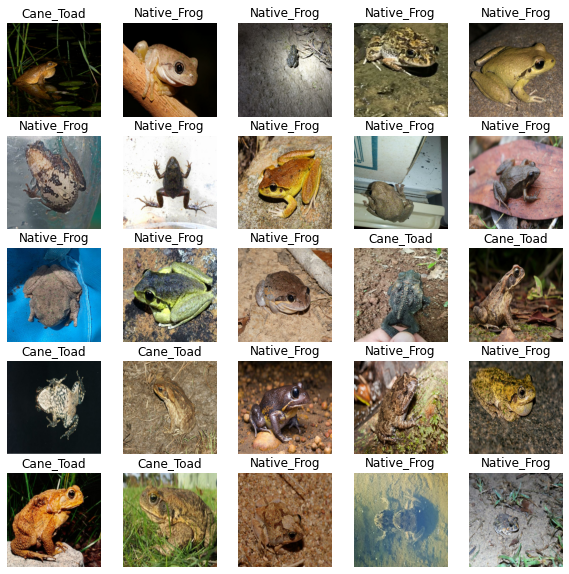

In [92]:
if view_samples:
    image_batch, label_batch = next(iter(train_ds))
    show_batch(image_batch.numpy(), label_batch.numpy())

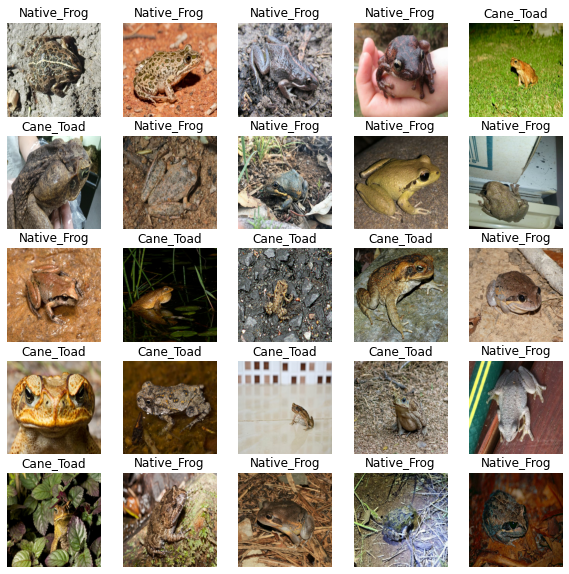

In [93]:
if view_samples:
    image_batch, label_batch = next(iter(val_ds))
    show_batch(image_batch.numpy(), label_batch.numpy())

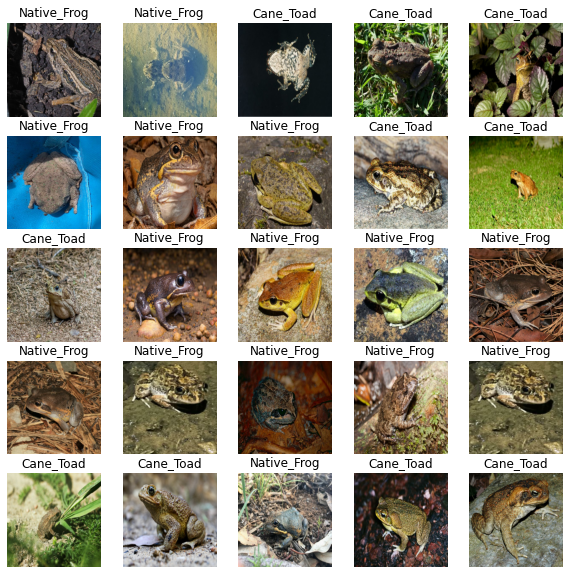

In [94]:
if view_samples:
    image_batch, label_batch = next(iter(test_ds))
    show_batch(image_batch.numpy(), label_batch.numpy())

In [95]:
# implement data augmentation as a layer in the model - better for training on GPU
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomContrast(0.2),
        layers.experimental.preprocessing.RandomFlip(),
        layers.experimental.preprocessing.RandomRotation(0.2),
        layers.experimental.preprocessing.RandomZoom(0.2),
    ]
)

In [96]:
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Dense, Flatten, 
Activation, Dropout, BatchNormalization, SeparableConv2D, Lambda)

def inception_module(x, s_1, s_2_1, s_2_2, s_3_1, s_3_2, s_4_2):
    stack_1 = Conv2D(filters=s_1,
                     kernel_size=1,
                     padding='same',
                     activation='relu',
                     )(x)

    stack_2 = Conv2D(filters=s_2_1,
                     kernel_size=1,
                     padding='same',
                     activation='relu',
                     )(x)
    stack_2 = Conv2D(filters=s_2_2,
                     kernel_size=3,
                     padding='same',
                     activation='relu',
                     )(stack_2)

    stack_3 = Conv2D(filters=s_3_1,
                     kernel_size=1,
                     padding='same',
                     activation='relu',
                     )(x)
    stack_3 = Conv2D(filters=s_3_2,
                     kernel_size=5,
                     padding='same',
                     activation='relu',
                     )(stack_3)

    stack_4 = MaxPooling2D(pool_size=3,
                           strides=1,
                           padding='same',
                           )(x)
    stack_4 = Conv2D(filters=s_4_2,
                     kernel_size=1,
                     padding='same',
                     activation='relu',
                     )(stack_4)

    concat = keras.layers.concatenate([stack_1, stack_2, stack_3, stack_4], axis=3)
    return concat

In [97]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Activation, Reshape, Permute, multiply

# function taken from https://github.com/RayXie29/SENet_Keras/blob/master/SENet.py

def SEBlock(se_ratio = 16, activation = "relu", data_format = 'channels_last', ki = "he_normal"):
    '''
    se_ratio : ratio for reduce the filter number of first Dense layer(fc layer) in block
    activation : activation function that of first dense layer
    data_format : channel axis is at the first of dimension or the last
    ki : kernel initializer
    '''

    def f(input_x):

        channel_axis = -1 if data_format == 'channels_last' else 1
        input_channels = input_x.shape[channel_axis]

        reduced_channels = input_channels // se_ratio

        #Squeeze operation
        x = GlobalAveragePooling2D()(input_x)
        x = Reshape(1,1,input_channels)(x) if data_format == 'channels_first' else x
        x = Dense(reduced_channels, kernel_initializer= ki)(x)
        x = Activation(activation)(x)
        #Excitation operation
        x = Dense(input_channels, kernel_initializer=ki, activation='sigmoid')(x)
        x = Permute(dims=(3,1,2))(x) if data_format == 'channels_first' else x
        x = multiply([input_x, x])

        return x

    return f

In [98]:
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Dense, Flatten, 
Activation, Dropout, BatchNormalization, SeparableConv2D, Lambda, GlobalAveragePooling2D)

def make_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # initial data augmentation layer
    x = data_augmentation(inputs)
    
    x = Conv2D(filters=64, 
               kernel_size=7, 
               padding='same',
               strides=2,
               )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = MaxPooling2D(pool_size=3,
                     strides=2,
                     padding='same',
                     )(x)

    x = Conv2D(filters=64, 
               kernel_size=1, 
               padding='same',
               strides=1,
               )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=192, 
               kernel_size=3, 
               padding='same',
               strides=1,
               )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = MaxPooling2D(pool_size=3,
                     strides=2,
                     padding='same',
                     )(x)

    x = inception_module(x, 64, 96, 128, 16, 32, 32)
    x = SEBlock()(x)
    x = inception_module(x, 128, 128, 192, 32, 96, 64)
    x = SEBlock()(x)

    x = MaxPooling2D(pool_size=3,
                     strides=2,
                     padding='same',
                     )(x)

    x = inception_module(x, 192, 96, 208, 16, 48, 64)
    x = SEBlock()(x)
    x = inception_module(x, 160, 112, 224, 24, 64, 64)
    x = SEBlock()(x)
    x = inception_module(x, 128, 128, 256, 24, 64, 64)
    x = SEBlock()(x)
    x = inception_module(x, 112, 144, 288, 32, 64, 64)
    x = SEBlock()(x)
    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = SEBlock()(x)

    x = MaxPooling2D(pool_size=3,
                     strides=2,
                     padding='same',
                     )(x)

    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = SEBlock()(x)
    x = inception_module(x, 384, 192, 384, 48, 128, 128)
    x = SEBlock()(x)

    x = GlobalAveragePooling2D()(x)
    
    x = Flatten()(x)

    x = Dropout(0.5)(x)

    outputs = Dense(units=num_classes, activation='sigmoid')(x)
    
    return keras.Model(inputs, outputs)

In [99]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [100]:
# if load_model:
#     model = keras.models.load_model(model_path)
# else:
#     model = make_model(input_shape=(IMG_WIDTH, IMG_HEIGHT) + (3,), 
#                        num_classes=len(CLASS_NAMES))
    
model = make_model(input_shape=(IMG_WIDTH, IMG_HEIGHT) + (3,), 
                   num_classes=len(CLASS_NAMES))    
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        sequential[0][0]                 
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
_______________________________________________________________________________________

In [101]:
from timeit import default_timer as timer
from tensorflow.keras.callbacks import EarlyStopping

if train:

    epochs = 200

    callback = EarlyStopping(monitor='val_accuracy', 
                             patience=20,
                             restore_best_weights=True,
                             )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    start = timer()

    history = model.fit(
        train_ds, 
        epochs=epochs, 
        callbacks=[callback],
        validation_data=val_ds,
        steps_per_epoch = train_size // BATCH_SIZE,
        validation_steps = val_size // BATCH_SIZE,
    )

    end = timer()

    if save_model:
        model.save(pathlib.Path(model_path))

Epoch 1/200
2/2 [==============================] - 0s 109ms/step - loss: 0.6942 - accuracy: 0.3594
Epoch 2/200
2/2 [==============================] - 0s 115ms/step - loss: 0.6933 - accuracy: 0.4844
Epoch 3/200
2/2 [==============================] - 0s 238ms/step - loss: 0.6932 - accuracy: 0.5156
Epoch 4/200
2/2 [==============================] - 0s 240ms/step - loss: 0.6924 - accuracy: 0.6094
Epoch 5/200
2/2 [==============================] - 0s 112ms/step - loss: 0.6928 - accuracy: 0.5312
Epoch 6/200
2/2 [==============================] - 0s 119ms/step - loss: 0.6933 - accuracy: 0.5000
Epoch 7/200
2/2 [==============================] - 0s 121ms/step - loss: 0.6901 - accuracy: 0.6250
Epoch 8/200
2/2 [==============================] - 0s 185ms/step - loss: 0.6911 - accuracy: 0.5469
Epoch 9/200
2/2 [==============================] - 0s 115ms/step - loss: 0.6926 - accuracy: 0.5312
Epoch 10/200
2/2 [==============================] - 0s 115ms/step - loss: 0.6889 - accuracy: 0.5312
Epoch 11/

Time elapsed (m): 2m7s
loss        0.455458
accuracy    0.781250
Name: 199, dtype: float64


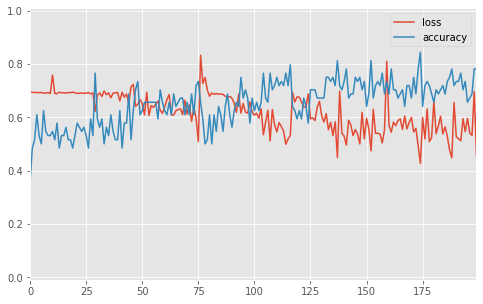

In [102]:
import pandas as pd

if train:

    seconds = round(end - start, 1)
    minutes = int(seconds / 60)
    m_seconds = int(seconds % 60)

    print("Time elapsed (m): {}m{}s".format(minutes, m_seconds))

    plt.style.use('ggplot')

    history_df = pd.DataFrame(history.history)
    num_epochs = history_df.shape[0]

    # if training has stopped early, print the best result 
    if num_epochs < epochs:
        print(history_df.loc[history_df['val_accuracy'] == history_df['val_accuracy'].max()])
        history_df.plot(figsize=(8, 5))
        plt.gca().set_ylim(-0.01, 1.01)
        plt.gca().set_xlim(-0.01, num_epochs-1)
    else:
        print(history_df.iloc[-1])
        history_df.plot(figsize=(8, 5))
        plt.gca().set_ylim(-0.01, 1.01)
        plt.gca().set_xlim(-0.01, epochs-1)

    if save_output:
        path = output_dir + '{}_learning_curves.png'.format(attempt)
        plt.savefig(pathlib.Path(path))

    plt.show()

In [104]:
test_loss, test_acc = model.evaluate(test_ds, 
                                     steps=test_size // BATCH_SIZE,
                                     )
print('\nTest accuracy:', test_acc)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:581: RuntimeWarning: divide by zero encountered in log10
  numdigits = int(np.log10(self.target)) + 1


OverflowError: ignored

In [105]:
test_image_batch, test_label_batch = next(iter(test_ds))

In [106]:
predictions = model.predict(test_image_batch)
predictions

array([[2.8070971e-01, 7.1871251e-01],
       [2.4833961e-01, 7.5825101e-01],
       [3.2766655e-01, 6.6855872e-01],
       [2.5736839e-01, 7.4565953e-01],
       [2.1702737e-01, 7.9224789e-01],
       [2.8711206e-01, 7.1215421e-01],
       [9.7595292e-01, 2.5905991e-02],
       [2.0636471e-01, 8.0166894e-01],
       [2.4626783e-01, 7.5760245e-01],
       [2.7829048e-01, 7.2172546e-01],
       [2.2673632e-01, 7.7906781e-01],
       [3.7199941e-01, 6.2363106e-01],
       [4.4984388e-01, 5.5303442e-01],
       [3.2983425e-01, 6.6832626e-01],
       [9.9924219e-01, 8.8331220e-04],
       [3.6790863e-01, 6.2767744e-01],
       [9.9728358e-01, 3.1794794e-03],
       [3.6013529e-01, 6.3817561e-01],
       [9.9675071e-01, 3.7995905e-03],
       [9.1316164e-01, 9.0768926e-02],
       [3.5492727e-01, 6.4220363e-01],
       [2.7937505e-01, 7.2720844e-01],
       [2.0636471e-01, 8.0166894e-01],
       [6.4368165e-01, 3.5773093e-01],
       [3.2253513e-01, 6.7956263e-01],
       [3.2766655e-01, 6.

In [111]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, np.argmax(true_label[i]), img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}%)".format(CLASS_NAMES[predicted_label],
                              100*np.max(predictions_array),
                              CLASS_NAMES[true_label]),
                              color=color)

def plot_value_array(i, predictions_array, true_label):   
    predictions_array, true_label = predictions_array, np.argmax(true_label[i])
    plt.grid(False)
    plt.xticks(range(len(CLASS_NAMES)), CLASS_NAMES, rotation=-45, ha="left", rotation_mode="anchor")
    plt.yticks([])
    thisplot = plt.bar(range(len(CLASS_NAMES)), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

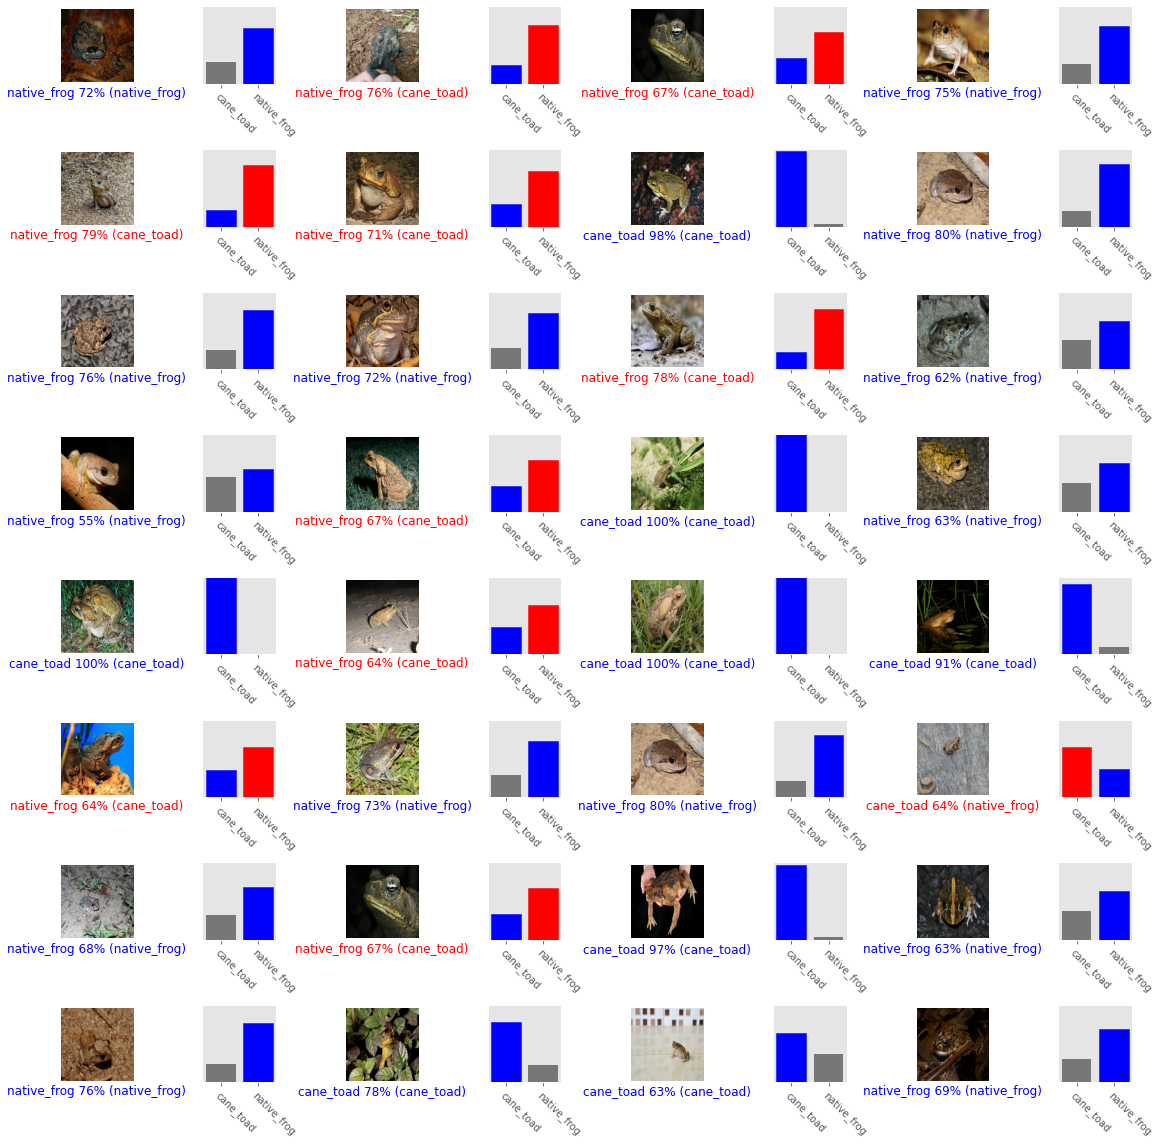

In [112]:
true_labels = [np.argmax(label) for label in test_label_batch]

while predictions.shape[0] < test_size:
    test_image_batch, test_label_batch = next(iter(test_ds))
    batch_predictions = model.predict(test_image_batch)
    predictions = np.vstack((predictions, batch_predictions))

    for i in range(BATCH_SIZE):
        true_labels.append(np.argmax(test_label_batch[i]))

    print("Total predictions:", predictions.shape[0])
    print("Total labels:", len(true_labels))

In [113]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

prediction_labels = [np.argmax(prediction) for prediction in predictions]

cm = confusion_matrix(true_labels, prediction_labels)
cr = classification_report(true_labels, prediction_labels, 
                           target_names=CLASS_NAMES,
                           digits=3, output_dict=True)
cr_df = pd.DataFrame(cr).transpose()

if save_output:
    cr_df.to_csv(output_dir + '{}_classification_report.csv'.format(attempt), index=True)

cr_df

,precision,recall,f1-score,support
cane_toad,0.888889,0.470588,0.615385,17.0000
native_frog,0.608696,0.933333,0.736842,15.0000
accuracy,0.687500,0.687500,0.687500,0.6875
macro avg,0.748792,0.701961,0.676113,32.0000
weighted avg,0.757548,0.687500,0.672318,32.0000


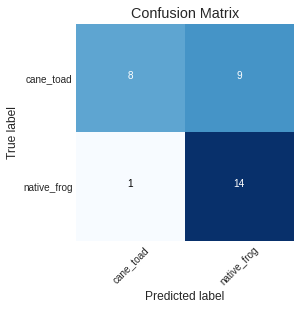

In [116]:
# so that `tools.py` can be imported
import sys
sys.path.append('/content/drive/My Drive/Cane_Toad_Image_Classification')
from tools import plot_confusion_matrix

plt.style.use('seaborn-dark')

plot_confusion_matrix(cm, classes=CLASS_NAMES, normalize=False, title="Confusion Matrix")

if save_output:
    plt.savefig(output_dir + '{}_confusion_matrix.png'.format(attempt))

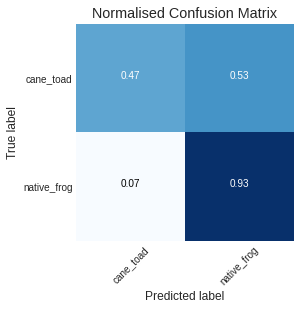

In [118]:
plot_confusion_matrix(cm, classes=CLASS_NAMES, normalize=True, title="Normalised Confusion Matrix")

if save_output:
    plt.savefig(output_dir + '{}_confusion_matrix_normalised.png'.format(attempt))

In [119]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

plt.style.use('ggplot')

lb = LabelBinarizer()
lb.fit(true_labels)
true_labels_one_hot = lb.transform(true_labels)

# code taken from `03_roc_curve` notebook in COMP3330 Week5_Notebooks

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(CLASS_NAMES)):
    fpr[i], tpr[i], _ = roc_curve(true_labels_one_hot[:,i], predictions[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

roc_auc

IndexError: ignored

KeyError: ignored

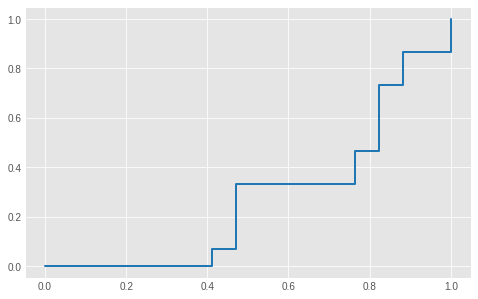

In [120]:
from itertools import cycle

# code taken from `03_roc_curve` notebook in COMP3330 Week5_Notebooks

plt.figure(figsize=(8, 5))
lw=2

colors = cycle(['tab:blue', 'tab:orange', 'tab:green', 'tab:cyan', 'tab:pink'])
for i, color in zip(range(len(CLASS_NAMES)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='{0} (area = {1:0.6f})'
             ''.format(CLASS_NAMES[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.01, 0.1])
plt.ylim([0.8, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class receiver operating characteristic')
plt.legend(loc="lower right")

if save_output:
    plt.savefig(output_dir + '{}_roc_auc.png'.format(attempt))

plt.show()

In [ ]:
# precision vs recall appropriate here